# Lab 4 – Bankruptcy Risk Assessment: Full Data Pipeline (16 Areas)

> Dataset assumed at `/mnt/data/data.csv` with target column **`Bankrupt?`**.
Run cells top-to-bottom. Each section maps to one lab area.

## 1) Load Data & Basic Overview

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Settings
pd.set_option('display.max_columns', 100)

# Load
df = pd.read_csv('data.csv')
print("Shape:", df.shape)
display(df.head())

# Basic checks
print("\nMissing values per column (top 20):")
display(df.isna().sum().sort_values(ascending=False).head(20))

# Ensure target exists
TARGET_COL = 'Bankrupt?'
assert TARGET_COL in df.columns, f"Expected target column '{TARGET_COL}' not found. Columns: {list(df.columns)[:10]}..."


Shape: (6819, 96)


,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,0.390284,0.006479,0.095885,0.137757,0.398036,0.086957,0.001814,0.003487,1.820926e-04,1.165007e-04,0.032903,0.034164,0.392913,0.037135,0.672775,0.166673,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,0.376760,0.005835,0.093743,0.168962,0.397725,0.064468,0.001286,0.004917,9.360000e+09,7.190000e+08,0.025484,0.0068


Missing values per column (top 20):


Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 Total expense/Assets                                       0
 Total income/Total expense                                 0
 Retained Earnings to Total Assets                          0
 Long-term Liability to Current Assets                      0
 Current Liabilities/Equity                                 0
 Working Capital/Equity                                     0
 Current Liabilities/Liability                              0
 Inventory/Current Liability                                0
 Inventory/Working Capital                                  0
 Operating Funds to Liability                               0
 Current Liability to Assets                                0
 Cash/Current Liability                                     0
 Quick Assets/Current Liability                             0
 Cash/Total Assets                                          0
 Current

## 2) Class Imbalance (for discussion & screenshots)

Counts:
 Bankrupt?
0    6599
1     220
Name: count, dtype: int64
Ratios:
 Bankrupt?
0    0.967737
1    0.032263
Name: count, dtype: float64


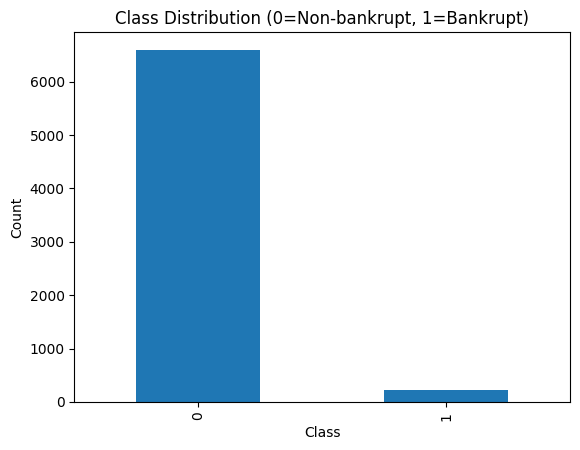

In [5]:

import matplotlib.pyplot as plt

class_counts = df[TARGET_COL].value_counts()
class_ratio = class_counts / class_counts.sum()
print("Counts:\n", class_counts)
print("Ratios:\n", class_ratio)

plt.figure()
df[TARGET_COL].value_counts().sort_index().plot(kind='bar')
plt.title("Class Distribution (0=Non-bankrupt, 1=Bankrupt)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


## 3) Stratified Train/Test Split

In [7]:

from sklearn.model_selection import train_test_split

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train.shape, X_test.shape, y_train.mean(), y_test.mean()


((5455, 95), (1364, 95), 0.03226397800183318, 0.03225806451612903)

## 4) Outlier Detection & Optional Treatment (Winsorization)

In [9]:

# Numeric-only columns (dataset is predominantly numeric)
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# IQR-based outlier summary (for info)
Q1 = X_train[num_cols].quantile(0.25)
Q3 = X_train[num_cols].quantile(0.75)
IQR = (Q3 - Q1).replace(0, np.nan)  # avoid zero IQR
outlier_mask = (X_train[num_cols] < (Q1 - 1.5*IQR)) | (X_train[num_cols] > (Q3 + 1.5*IQR))
outlier_counts = outlier_mask.sum().sort_values(ascending=False)
display(outlier_counts.head(10))

# Optional Winsorization (disabled by default). Set DO_WINSORIZE=True to apply.
DO_WINSORIZE = False
if DO_WINSORIZE:
    lower = X_train[num_cols].quantile(0.01)
    upper = X_train[num_cols].quantile(0.99)
    X_train[num_cols] = X_train[num_cols].clip(lower=lower, upper=upper, axis=1)
    # Apply same bounds to test to avoid leakage
    X_test[num_cols] = X_test[num_cols].clip(lower=lower, upper=upper, axis=1)

print("Winsorization applied?" , DO_WINSORIZE)


Degree of Financial Leverage (DFL)                    1193
Fixed Assets Turnover Frequency                       1138
Interest Coverage Ratio (Interest expense to EBIT)    1138
Current Asset Turnover Rate                           1116
Total Asset Growth Rate                               1097
Interest Expense Ratio                                1097
Cash Flow to Liability                                 987
No-credit Interval                                     913
Non-industry income and expenditure/revenue            901
Continuous Net Profit Growth Rate                      839
dtype: int64

Winsorization applied? False


## 5) Class Imbalance Handling: Class Weights vs SMOTE (comparison scaffolding)

In [11]:

from imblearn.over_sampling import SMOTE

# Compute class_weight dict for y_train
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
CLASS_WEIGHT = {c: w for c, w in zip(classes, class_weights)}
CLASS_WEIGHT


{0: 0.5166698238302709, 1: 15.497159090909092}

In [12]:

# Prepare SMOTE-resampled training set (to be used in some experiments)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
y_train.value_counts(), y_train_smote.value_counts()


(Bankrupt?
 0    5279
 1     176
 Name: count, dtype: int64,
 Bankrupt?
 0    5279
 1    5279
 Name: count, dtype: int64)

## 6) Data Normalization Strategy (StandardScaler for LR/SVM; not needed for trees)

In [14]:

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

scaler = StandardScaler()
scale_transformer = ColumnTransformer(
    transformers=[('num', scaler, num_cols)],
    remainder='passthrough'
)

# Example: scale X_train / X_test for models that need it
X_train_scaled = scale_transformer.fit_transform(X_train)
X_test_scaled = scale_transformer.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape


((5455, 95), (1364, 95))

## 7) Testing for Normality (via skewness) & Optional Log Transform

In [16]:

# Skewness summary
skews = X_train[num_cols].skew().sort_values(ascending=False)
display(skews.head(10))
display(skews.tail(10))

# Optional: log1p transform highly skewed positive features (disabled by default)
DO_LOG_TRANSFORM = False
SKEW_THRESHOLD = 2.0
skewed_pos_cols = [c for c in num_cols if (skews.get(c,0)>SKEW_THRESHOLD) and (X_train[c].min()>=0)]
if DO_LOG_TRANSFORM and len(skewed_pos_cols)>0:
    for c in skewed_pos_cols:
        X_train[c] = np.log1p(X_train[c])
        X_test[c] = np.log1p(X_test[c])
print("Log transform applied?", DO_LOG_TRANSFORM, "on", len(skewed_pos_cols), "columns")


Fixed Assets to Assets               73.857972
Revenue per person                   73.857972
Net Value Growth Rate                73.857972
Total income/Total expense           73.696400
Contingent liabilities/Net worth     71.851026
Working capitcal Turnover Rate       67.086353
Cash Flow to Sales                   60.865866
Continuous Net Profit Growth Rate    60.583558
Inventory/Working Capital            51.662829
Total debt/Total net worth           51.469930
dtype: float64

After-tax Net Profit Growth Rate       -26.354195
Net Income to Stockholder's Equity     -27.992655
Interest Expense Ratio                 -28.114015
Working Capital/Equity                 -36.591335
After-tax net Interest Rate            -60.453438
Pre-tax net Interest Rate              -61.366903
Continuous interest rate (after tax)   -62.793439
Total Asset Return Growth Rate Ratio   -63.884141
Operating Profit Growth Rate           -69.095968
Operating Profit Rate                  -73.363739
dtype: float64

Log transform applied? False on 53 columns


## 8) PCA (Optional): Dimensionality Reduction & Explained Variance

In [18]:

from sklearn.decomposition import PCA

DO_PCA = False
N_COMPONENTS = min(20, X_train.shape[1])  # cap components for demo
pca = PCA(n_components=N_COMPONENTS, random_state=42)

if DO_PCA:
    X_train_pca = pca.fit_transform(StandardScaler().fit_transform(X_train[num_cols]))
    X_test_pca = pca.transform(StandardScaler().fit_transform(X_test[num_cols]))
    print("Explained variance (first 10):", np.round(pca.explained_variance_ratio_[:10], 4))
else:
    X_train_pca = None
    X_test_pca = None
print("PCA enabled?", DO_PCA)


PCA enabled? False


## 9) Feature Engineering (minimal; example-derived)

In [20]:

# Minimal, generic engineered features for demonstration (dataset already ratio-heavy)
# 1) Count of positive-valued financial ratios per row
X_train_eng = X_train.copy()
X_test_eng = X_test.copy()

X_train_eng['num_positive_feats'] = (X_train_eng[num_cols] > 0).sum(axis=1)
X_test_eng['num_positive_feats'] = (X_test_eng[num_cols] > 0).sum(axis=1)

# 2) Row-wise z-score outlier count (how many features are > |3| std from train mean)
train_mean = X_train[num_cols].mean()
train_std = X_train[num_cols].std().replace(0, np.nan)
z_scores = (X_train[num_cols] - train_mean) / train_std
X_train_eng['num_extreme_z'] = (z_scores.abs() > 3).sum(axis=1)

z_scores_test = (X_test[num_cols] - train_mean) / train_std
X_test_eng['num_extreme_z'] = (z_scores_test.abs() > 3).sum(axis=1)

X_train_eng.shape, X_test_eng.shape


((5455, 97), (1364, 97))

## 10) Multicollinearity Checks: Correlation & VIF

In [22]:

# Correlation matrix (train)
corr = X_train[num_cols].corr().abs()
high_corr_pairs = [(i,j,corr.loc[i,j]) for i in corr.columns for j in corr.columns if i<j and corr.loc[i,j]>0.9]
print("Highly correlated pairs (>0.9): count=", len(high_corr_pairs))
high_corr_pairs[:5]


Highly correlated pairs (>0.9): count= 36


[(' ROA(A) before interest and % after tax',
  ' ROA(C) before interest and depreciation before interest',
  0.9396924924128035),
 (' ROA(A) before interest and % after tax',
  ' ROA(B) before interest and depreciation after tax',
  0.9564740393009181),
 (' ROA(B) before interest and depreciation after tax',
  ' ROA(C) before interest and depreciation before interest',
  0.9866322682403741),
 (' Operating Gross Margin',
  ' Realized Sales Gross Margin',
  0.9994645573228145),
 (' Operating Profit Rate', ' Pre-tax net Interest Rate', 0.9423734788224656)]

In [23]:

# VIF calculation (fallback if statsmodels not available)
try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    import statsmodels.api as sm

    X_for_vif = X_train[num_cols].fillna(X_train[num_cols].median())
    # add small jitter to perfectly collinear columns to avoid singularities
    X_for_vif = X_for_vif + np.random.normal(0, 1e-9, X_for_vif.shape)

    vifs = []
    for i, col in enumerate(num_cols):
        vif = variance_inflation_factor(X_for_vif.values, i)
        vifs.append((col, vif))
    vif_df = pd.DataFrame(vifs, columns=['feature','VIF']).sort_values('VIF', ascending=False)
    display(vif_df.head(10))
except Exception as e:
    print("VIF skipped (statsmodels not available or failed):", e)


,feature,VIF
63,Current Liabilities/Liability,6.505084e+10
76,Current Liability to Liability,2.407396e+10
55,Current Assets/Total Assets,2.287200e+10
53,Working Capital to Total Assets,7.875126e+09
59,Current Liability to Assets,5.891733e+09
65,Current Liabilities/Equity,1.547663e+09
77,Current Liability to Equity,1.497194e+09
36,Debt ratio %,4.020174e+08
37,Net worth/Assets,3.898123e+08
5,Operating Profit Rate,1.285223e+08


## 11) Feature Selection: Correlation Filter, L1-LogReg, Model-Based

In [25]:

# (a) Correlation filter: drop one of any pair with corr > 0.95
to_drop = set()
corr_thr = 0.95
for i in corr.columns:
    for j in corr.columns:
        if i<j and corr.loc[i,j] > corr_thr and j not in to_drop:
            to_drop.add(j)
len(to_drop), list(to_drop)[:10]


(19,
 [' Working capitcal Turnover Rate',
  ' Net Value Per Share (C)',
  ' Net worth/Assets',
  ' Regular Net Profit Growth Rate',
  ' ROA(B) before interest and depreciation after tax',
  ' Continuous interest rate (after tax)',
  ' Operating Gross Margin',
  ' Pre-tax net Interest Rate',
  ' Per Share Net profit before tax (Yuan ¥)',
  ' Current Liability to Liability'])

In [26]:

# (b) L1-regularized Logistic Regression for selection
from sklearn.linear_model import LogisticRegression

lr_l1 = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('clf', LogisticRegression(penalty='l1', solver='saga', max_iter=2000, class_weight='balanced', random_state=42))
])

lr_l1.fit(X_train[num_cols], y_train)
coef = lr_l1.named_steps['clf'].coef_.ravel()
selected_l1 = [col for col, c in zip(num_cols, coef) if abs(c) > 1e-6]
len(selected_l1), selected_l1[:10]


C:\Users\rvith\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


(84,
 [' ROA(C) before interest and depreciation before interest',
  ' ROA(A) before interest and % after tax',
  ' ROA(B) before interest and depreciation after tax',
  ' Operating Gross Margin',
  ' Operating Profit Rate',
  ' Pre-tax net Interest Rate',
  ' After-tax net Interest Rate',
  ' Non-industry income and expenditure/revenue',
  ' Operating Expense Rate',
  ' Research and development expense rate'])

In [27]:

# (c) Model-based importance (XGBoost if available; else RandomForest)
selected_model_features = None
feature_importances = None

try:
    from xgboost import XGBClassifier
    xgb = XGBClassifier(
        n_estimators=200, max_depth=4, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8, eval_metric='logloss',
        random_state=42, n_jobs=-1, scale_pos_weight=(y_train==0).sum()/(y_train==1).sum()
    )
    xgb.fit(X_train, y_train)
    feature_importances = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    selected_model_features = feature_importances.head(30).index.tolist()
except Exception as e:
    from sklearn.ensemble import RandomForestClassifier
    rf = RandomForestClassifier(
        n_estimators=300, max_depth=None, class_weight='balanced',
        random_state=42, n_jobs=-1
    )
    rf.fit(X_train, y_train)
    feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    selected_model_features = feature_importances.head(30).index.tolist()

display(feature_importances.head(10))
selected_model_features[:10]


Persistent EPS in the Last Four Seasons        0.080007
Total debt/Total net worth                     0.076178
Continuous interest rate (after tax)           0.074659
Borrowing dependency                           0.046699
Net Income to Total Assets                     0.044126
Net worth/Assets                               0.042876
Retained Earnings to Total Assets              0.025100
Current Liability to Current Assets            0.021466
Non-industry income and expenditure/revenue    0.021141
Interest Expense Ratio                         0.020667
dtype: float32

[' Persistent EPS in the Last Four Seasons',
 ' Total debt/Total net worth',
 ' Continuous interest rate (after tax)',
 ' Borrowing dependency',
 ' Net Income to Total Assets',
 ' Net worth/Assets',
 ' Retained Earnings to Total Assets',
 ' Current Liability to Current Assets',
 ' Non-industry income and expenditure/revenue',
 ' Interest Expense Ratio']

## 12) Hyperparameter Tuning (RandomizedSearchCV examples)

In [29]:

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, average_precision_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(average_precision_score, needs_proba=True)  # PR-AUC

# Example: Logistic Regression tuning
pipe_lr = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', solver='saga', random_state=42))
])
param_lr = {
    'clf__C': np.logspace(-3, 2, 20),
    'clf__penalty': ['l1','l2']
}
rs_lr = RandomizedSearchCV(pipe_lr, param_distributions=param_lr, n_iter=20, cv=cv, scoring='roc_auc', n_jobs=-1, random_state=42)
rs_lr.fit(X_train, y_train)
rs_lr.best_params_, rs_lr.best_score_


({'clf__penalty': 'l1', 'clf__C': 0.011288378916846888}, 0.9315752480799875)

In [30]:

# Example: RandomForest tuning
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
param_rf = {
    'n_estimators': [200, 400, 600, 800],
    'max_depth': [None, 4, 6, 8, 12],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}
rs_rf = RandomizedSearchCV(rf, param_distributions=param_rf, n_iter=20, cv=cv, scoring='roc_auc', n_jobs=-1, random_state=42)
rs_rf.fit(X_train, y_train)
rs_rf.best_params_, rs_rf.best_score_


({'n_estimators': 800,
  'min_samples_split': 5,
  'min_samples_leaf': 2,
  'max_features': 'log2',
  'max_depth': None},
 0.9398129654705484)

## 13) Cross-Validation Strategy (Stratified K-Fold)

In [32]:

from sklearn.model_selection import cross_val_score

auc_scores = cross_val_score(rs_rf.best_estimator_, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
pr_scores = cross_val_score(rs_rf.best_estimator_, X_train, y_train, cv=cv, scoring='average_precision', n_jobs=-1)
f1_scores = cross_val_score(rs_rf.best_estimator_, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)

print("CV ROC-AUC:", np.round(auc_scores.mean(),4), "+/-", np.round(auc_scores.std(),4))
print("CV PR-AUC:", np.round(pr_scores.mean(),4), "+/-", np.round(pr_scores.std(),4))
print("CV F1:", np.round(f1_scores.mean(),4), "+/-", np.round(f1_scores.std(),4))


CV ROC-AUC: 0.9398 +/- 0.0198
CV PR-AUC: 0.4198 +/- 0.0851
CV F1: 0.2787 +/- 0.1245


## 14) Evaluation Metrics on Test Set (ROC-AUC, F1, PR-AUC, Brier Score)

In [34]:

from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, brier_score_loss, precision_recall_curve, roc_curve

best_model = rs_rf.best_estimator_
best_model.fit(X_train, y_train)
y_proba = best_model.predict_proba(X_test)[:,1]
y_pred = (y_proba >= 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)
brier = brier_score_loss(y_test, y_proba)

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC:  {pr_auc:.4f}")
print(f"F1:      {f1:.4f}")
print(f"Brier:   {brier:.4f}")


ROC-AUC: 0.9521
PR-AUC:  0.5118
F1:      0.3934
Brier:   0.0216


## 15) Evaluating Drift: PSI between Train and Test

In [36]:

def psi(expected, actual, buckets=10):
    """Population Stability Index between two numeric arrays."""
    expected = pd.Series(expected).dropna().values
    actual = pd.Series(actual).dropna().values
    # protect against constant arrays
    if np.all(expected == expected[0]) or np.all(actual == actual[0]):
        return 0.0
    # percentile breakpoints based on expected
    quantiles = np.linspace(0, 100, buckets+1)
    bins = np.unique(np.percentile(expected, quantiles))  # unique to avoid zero-width bins
    if len(bins) <= 2:
        return 0.0
    e_hist, _ = np.histogram(expected, bins=bins)
    a_hist, _ = np.histogram(actual, bins=bins)
    e_perc = e_hist / max(e_hist.sum(), 1)
    a_perc = a_hist / max(a_hist.sum(), 1)
    # avoid division by zero
    e_perc = np.clip(e_perc, 1e-6, None)
    a_perc = np.clip(a_perc, 1e-6, None)
    return float(np.sum((e_perc - a_perc) * np.log(e_perc / a_perc)))

psi_scores = {col: psi(X_train[col], X_test[col]) for col in X.columns}
psi_df = pd.DataFrame({'Feature': list(psi_scores.keys()), 'PSI': list(psi_scores.values())}).sort_values('PSI', ascending=False)
display(psi_df.head(15))


,Feature,PSI
51,Operating profit per person,0.020157
53,Working Capital to Total Assets,0.019572
12,Cash flow rate,0.018993
8,Non-industry income and expenditure/revenue,0.018806
54,Quick Assets/Total Assets,0.017547
64,Working Capital/Equity,0.017045
83,Current Liability to Current Assets,0.016758
22,Per Share Net profit before tax (Yuan ¥),0.016620
32,Current Ratio,0.016597
61,Inventory/Working Capital,0.015222


## 16) Interpretability: LR Coefficients & Permutation Importance

In [38]:

# Logistic Regression for interpretability
lr_interpret = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear', random_state=42))
])
lr_interpret.fit(X_train, y_train)

coef_series = pd.Series(lr_interpret.named_steps['clf'].coef_.ravel(), index=X_train.columns)
display(coef_series.sort_values(ascending=False).head(10))
display(coef_series.sort_values(ascending=True).head(10))


Borrowing dependency                      1.643905
Total debt/Total net worth                0.933537
ROA(A) before interest and % after tax    0.931203
Operating profit/Paid-in capital          0.877432
Debt ratio %                              0.858445
Net Value Per Share (C)                   0.667184
Working capitcal Turnover Rate            0.611662
Operating Profit Per Share (Yuan ¥)       0.524034
Operating Profit Rate                     0.432214
Pre-tax net Interest Rate                 0.425364
dtype: float64

Persistent EPS in the Last Four Seasons       -2.268296
Liability to Equity                           -1.811768
Equity to Liability                           -1.615916
Current Ratio                                 -1.518077
Net Income to Total Assets                    -1.276768
Accounts Receivable Turnover                  -1.226217
Net Value Per Share (B)                       -1.216578
Net worth/Assets                              -0.858445
Inventory and accounts receivable/Net value   -0.795694
Cash Flow to Liability                        -0.787184
dtype: float64

In [39]:

# Permutation importance on best model
from sklearn.inspection import permutation_importance

perm = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances = pd.Series(perm.importances_mean, index=X_test.columns).sort_values(ascending=False)
display(perm_importances.head(15))


Persistent EPS in the Last Four Seasons                    0.002859
Quick Ratio                                                0.002859
Continuous interest rate (after tax)                       0.002053
ROA(B) before interest and depreciation after tax          0.001686
Revenue per person                                         0.001613
Borrowing dependency                                       0.001540
Inventory/Working Capital                                  0.001466
Retained Earnings to Total Assets                          0.001393
ROA(C) before interest and depreciation before interest    0.001320
Debt ratio %                                               0.001320
Total debt/Total net worth                                 0.001320
Quick Assets/Current Liability                             0.001173
Total Asset Growth Rate                                    0.001026
Equity to Liability                                        0.001026
Inventory/Current Liability                     